## Outliers

Outliers are data points that we dont want to consider in our fit. The reasons can be different. It might be spurious signal falling on the detector, like glitches, or in principle valid signal that cannot be considered in the model at hand.

Here we present the same data as in the methanol example. See there for explanation of the construction of the spectrum. 

Part of that spectrum (around 500 GHz) shows a sinusoidal background signal, which is caused by aliasing in the deconvolution process. 

We want to fit the background with a sine function. All absorption lines in the spectrum are outliers and should be disregarded.

In this example we use RobustShell to iteratively reweight the datapoints. 

Demonstration: 
    1. Compound model of sine + constant
    2. LevenbergMarquardtFitter 
    3. RobustShell

Author: Do Kester


We need to import some classes

In [1]:
import numpy as numpy
import math

from astropy.io import fits
from BayesicFitting import SineModel
from BayesicFitting import PolynomialModel
from BayesicFitting import ExpModel
from BayesicFitting import ExponentialPrior
from BayesicFitting import LevenbergMarquardtFitter
from BayesicFitting import RobustShell
from BayesicFitting import formatter as fmt
from BayesicFitting import Tools
from BayesicFitting import plotFit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [2]:
# uncomment the next line to get the plots in a separate scalable 
# window.

#%matplotlib osx

%matplotlib inline

Read the data

In [3]:
hdu = fits.open( "data/Decgf-Methanol-1-5.fits" )

In [4]:
data = hdu[1].data
flux = data.field( 0 )
freq = data.field( 1 )
covr = data.field( 2 )


Select the part between 490 and 560 GHz, where the background is aliased.

140000


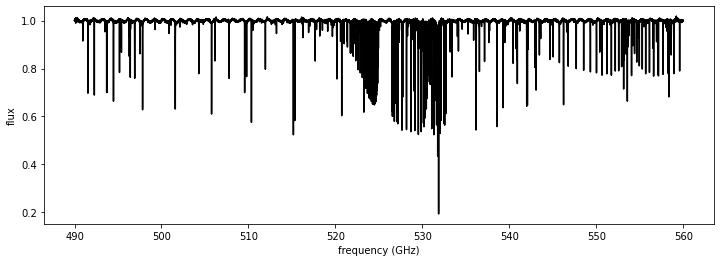

In [5]:
q = numpy.where( numpy.logical_and( freq > 490, freq < 560 ))
flx = flux[q]
frq = freq[q]
cov = covr[q]
print( len( flx ) )
plt.figure( "490 to 560", figsize=(12,4) )
plt.plot( frq, flx, 'k-')
plt.ylabel( "flux" )
plt.xlabel( "frequency (GHz)" )

plt.show()


Make a compound model consisting of a SineModel plus a constant: PolynomialModel( 0 ).

In [6]:
sm = SineModel()
pm = PolynomialModel( 0 )
model = pm + sm


Define a non-linear fitter (LevenbergMarquardtFitter) and wrap a robustifier (RobustShell) around it. 

RobustShell is a fitter which contains another fitter.

In [7]:
lmf = LevenbergMarquardtFitter( frq, model )
ftr = RobustShell( lmf )

pars = ftr.fit( flx )
print( "params  ", fmt( pars ) )
print( "stdevs  ", fmt( ftr.stdevs ) )
print( "scale   ", fmt( ftr.scale ) )
lo = [ 0.9, 0.9, -0.1, -0.1]
hi = [ 1.1, 1.1, +0.1, +0.1]
ev1 = ftr.getEvidence( limits=[lo,hi] )
print( "evidence  ", fmt( ev1 ) )

params   [    1.000    1.000    0.004    0.003]
stdevs   [    0.000    0.000    0.000    0.000]
scale        0.002
evidence    -55877.958


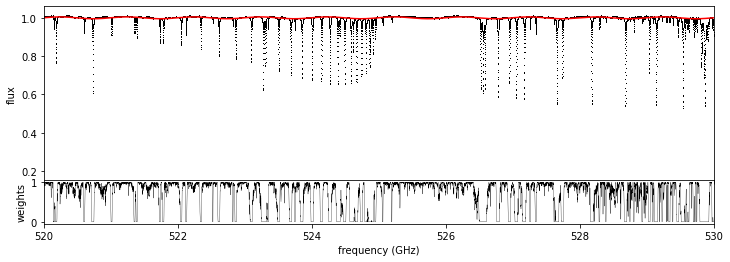

In [8]:
rwgt = ftr.weights

plt.figure( 1, figsize=(12,4) )
plt.subplots_adjust( hspace=0.001 )

gs = gridspec.GridSpec( 2, 1, height_ratios=[4, 1])
        
ax0 = plt.subplot( gs[0] )
ax0.plot( frq, flx, 'k,' )
ax0.plot( frq, model( frq ), 'r-' )
y0axis = ax0.get_yaxis()
plt.ylabel( "flux" )
xticklabels = ax0.get_xticklabels()
plt.setp( xticklabels, visible=False )

ax1 = plt.subplot( gs[1] )
ax1.plot( frq, rwgt, 'k-', linewidth=0.3 )

# Show only a small piece. 
# Comment the next 2 line to see all
ax0.set_xlim( [520, 530] )
ax1.set_xlim( [520, 530] )

plt.xlabel( "frequency (GHz)" )
plt.ylabel( "weights" )
plt.show()
